## ITMLA3 Exam Prep Class 1 (18/04/2024)

Before running the code, make sure to change the filepath to where you saved the images for this code.

Steps:
1. Open Anaconda in the right environment and open Notebooks.
2. Create a folder named 'ITMLA Exam Prep'.
3. Extraxt the images from the images.zip folder added to the Repository
4. Make sure the extracted file is named "images" on your computer.
5. Copy the filepath to each and paste it into the 'defective_folder' and 'defectless_folder'.
6. Your code should now run. 

### Libraries


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


### Import Image Dataset and do preprocessing, image enhancement, feature extraction and normalization

Loading defective images: Dimensions resized to 200px200p
Images loaded: 100 Status: ALL IMAGES LOADED SUCCESSFULLY
----------------------------------------------------------------------------------
Loading defectless images: Dimensions resized to 200px200p
Images loaded: 100 Status: ALL IMAGES LOADED SUCCESSFULLY
----------------------------------------------------------------------------------
Loading samples of processed and classified images by their respective label:


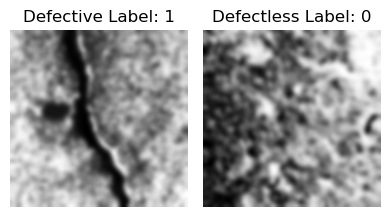

In [95]:
defective_folder = r'C:\Users\stefw\Desktop\GIT\ITMLA Exam Prep\images\project\defective'
defectless_folder = r'C:\Users\stefw\Desktop\GIT\ITMLA Exam Prep\images\project\defectless'

###################################################################################################################################################
#Feature extraction functions:

def canny_feature_extraction(image, threshold1=100, threshold2=200):
    #Apply Canny edge detection
    edges = cv2.Canny(image, threshold1=threshold1, threshold2=threshold2)
    #Flatten the edge image to obtain a feature cevtor
    feature_vector = edges.flatten()

    return feature_vector

def hog_feature_extraction(image):
    #Initialize HOG descriptor
    hog = cv2.HOGDescriptor()
    #Compute HOF features
    hog_features = hog.compute(image)
    #Flatten the feature vector
    feature_vector = hog_features.flatten()

    return feature_vector
    
def lbp_feature_extraction(image, radius=1, n_points=8):
    # Compute LBP features
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    
    # Flatten the LBP image to obtain a feature vector
    feature_vector = lbp.ravel()
    
    return feature_vector

###################################################################################################################################################
#Image enhancement functions:

def bilateral_filter(image, d, sigma_color, sigma_space):
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image
 
def median_blur(image, kernel_size):
    blurred_image = cv2.medianBlur(image, kernel_size)
    return blurred_image
 
def mean_blur(image, kernel_size):
    blurred_image = cv2.blur(image, (kernel_size, kernel_size))
    return blurred_image

###################################################################################################################################################
#Here we do contrast stretching of the image
def contrast_stretching(image):
    # Calculate minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)
    # Perform contrast stretching
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    stretched_image = stretched_image.astype(np.uint8)
    return stretched_image
###################################################################################################################################################
#Another contrast strecting method:

# def contrast_stretching(image):
#     # Perform contrast stretching
#     stretched_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     return stretched_image

 
###################################################################################################################################################
#Can also not use functions and directly input into image_enchancement function
#Change the image enhancement method here to effect changes across the rest of the program. Remember to return the correct image variable.
def image_enhancement(image):
    
    #Equalizing image data
    image_eq = cv2.equalizeHist(image)
    #image_eq = contrast_stretching(image)
   
    ##Change the image enhancement method here to remove noise from the images:
    image_blur_Gauss = cv2.GaussianBlur(image_eq, (15, 15), 0)
    #image_blur_bilat =  bilateral_filter(image_eq, 9, 75, 75) # Input values: d- higher values for more blur, sig_c & sig_s- higher blurs more colors
    #image_median_blur = median_blur(image_eq, 5) #Higer kernel size will blur the image more
    #image_mean_blur = mean_blur(image_eq, 15) #Adjust kernel size as needed ex. 5, 7, 10
       
    return image_blur_Gauss
###################################################################################################################################################
#Load images from file, preprocess, enhance, add labels and display how many images loaded successfully

def load_and_preprocess_images(folder, label):
    images = []
    labels = []
    features = []
    c = 0
    num_img_in_file = 100 #Change this number to the amount of images in the file that needs to be loaded. 
    
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        c += 1
        if img is not None:
            resized_img = cv2.resize(img, (200, 200))
            enh_img = image_enhancement(resized_img)
            fet_vec = canny_feature_extraction(enh_img)
            images.append(enh_img)
            labels.append(label)
            features.append(fet_vec)
    #Used to check if all the images loaded successfully and alerts if file sizes are not even        
    if c == num_img_in_file: 
        print(f"Images loaded: {c} Status: ALL IMAGES LOADED SUCCESSFULLY")
    else:
        print(f"Images loaded: {c} Status: MISSING IMAGES")
        print(f"Amount of Images missing: {num_img_in_file-c}")
        
    return images, labels, features

#Loading the images using the load_and_preprocess_images function
print("Loading defective images: Dimensions resized to 200px200p")
defective_images, defective_labels, defective_features = load_and_preprocess_images(defective_folder, 1)

print("----------------------------------------------------------------------------------")
print("Loading defectless images: Dimensions resized to 200px200p")
defectless_images, defectless_labels, defectless_features = load_and_preprocess_images(defectless_folder, 0)


#Displaying the images using the display_sidebyside function
def display_sidebyside(defect_no, defectless_number):
    #Assign images
    defectless_img = defectless_images[defectless_number]
    defective_img = defective_images[defect_no]
 
    #Assign labels
    defectless_label = defectless_labels[defectless_number]
    defective_label = defective_labels[defect_no]
    # Create a figure and axis objects
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))
    
    #Display the first image with its label
    axes[0].imshow(defective_img, cmap='gray')
    axes[0].set_title(f"Defective Label: {defective_label}")
    axes[0].axis('off')
 
    #Display the second image with its label
    axes[1].imshow(defectless_img, cmap='gray')
    axes[1].set_title(f"Defectless Label: {defectless_label}" )
    axes[1].axis('off')
 
    #Adjust layout and display the images
    plt.tight_layout()
    plt.show()

#Displaying processed sample images taken from the defective_folder and the defectless_folder variables created earlier
print("----------------------------------------------------------------------------------")
print("Loading samples of processed and classified images by their respective label:")
img_num = 0 #Change this to select another image from the folders (0-99 for this example)
display_sidebyside(img_num,img_num)

#### Show sample images individually using matplotlib

##### Showing defective image sample

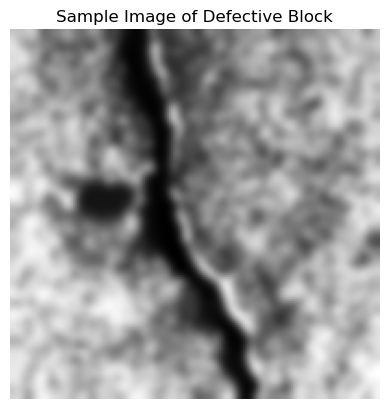

In [96]:
#Show sample image of defective block

img_num = 0 #Enter a number from 0 to 99 for this example
plt.imshow(defective_images[img_num], cmap='gray')
plt.title('Sample Image of Defective Block')
plt.axis('off')  # Turn off the axes
plt.grid(False)  # Turn off the grid
plt.show()

##### Showing defectless image sample

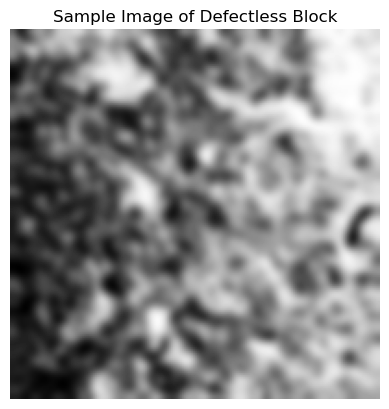

In [97]:
#Show sample image of defectless block
img_num = 0 #Enter a number from 0 to 99 for this example
plt.imshow(defectless_images[img_num], cmap='gray')
plt.title('Sample Image of Defectless Block')
plt.axis('off')  # Turn off the axes
plt.grid(False)  # Turn off the grid
plt.show()

##### Loading the images with their respective file allocations 

Defective images will be labeled as 1
Defectless images will be labeled as 0

----------------------------------------------------------------------------------
Loading samples of classified images by their respective label:


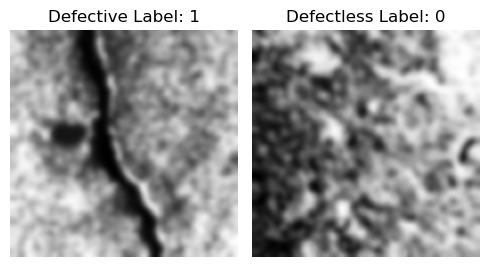

In [98]:
def display_sidebyside(defect_no, defectless_number):
    #assign images
    defectless_img = defectless_images[defectless_number]
    defective_img = defective_images[defect_no]
 
    #Assign labels
    defectless_label = defectless_labels[defectless_number]
    defective_label = defective_labels[defect_no]
    # Create a figure and axis objects
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    
    # Display the first image with its label
    axes[0].imshow(defective_img, cmap='gray')
    axes[0].set_title(f"Defective Label: {defective_label}")
    axes[0].axis('off')
 
    # Display the second image with its label
    axes[1].imshow(defectless_img, cmap='gray')
    axes[1].set_title(f"Defectless Label: {defectless_label}" )
    axes[1].axis('off')
 
    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()
print("----------------------------------------------------------------------------------")
print("Loading samples of classified images by their respective label:")
img_num = 0
display_sidebyside(img_num,img_num)

### Combining Data

In [62]:
X = np.array(defective_features + defectless_features)
y = defective_labels + defectless_labels

#Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

print("----------------------------------------------------------------------------------")
print("Scaled features matrix")
print(X_scaled.shape)  # Print the shape of the scaled data.
print("----------------------------------------------------------------------------------")

----------------------------------------------------------------------------------
Scaled features matrix
(200, 680400)
----------------------------------------------------------------------------------


### Classifiers

#### Information on the use of Classifiers

Multi-Layer Perceptron (MLP) classifiers, Random Forest classifiers, and Support Vector Machine (SVM) classifiers offer distinct approaches to machine learning tasks. MLP classifiers, with their layered neural network architecture, excel in capturing complex patterns in data, making them suitable for tasks like image recognition and natural language processing. Random Forest classifiers, through ensemble learning, provide robustness against noise and scalability, making them effective in domains such as remote sensing and finance. SVM classifiers, by maximizing the margin between classes, offer strong performance in binary classification tasks with high-dimensional data, often found in text and image classification. Understanding the characteristics and requirements of the dataset and the problem domain is crucial in choosing the most suitable classifier for a given machine learning task.

Following, a summary of each classifier and where they are best suited for machine learning:

1. **Multi-Layer Perceptron (MLP) Classifier**:
   * **Description**: A type of artificial neural network with multiple layers of nodes. It learns complex patterns in data through forward and backward propagation.
   * **Best Suited for**: MLP classifiers are versatile and can be used in various tasks such as image recognition, natural language processing, and time-series prediction. They excel in situations where data has complex nonlinear relationships and large feature spaces.

2. **Random Forest Classifier**:
   * **Description**:An ensemble learning method that constructs multiple decision trees during training and outputs the mode (classification) or mean (regression) of the individual trees.
   * **Best Suited for**: Random Forest classifiers are effective for tasks where interpretability, scalability, and handling of high-dimensional data are important. They are widely used in applications such as remote sensing, bioinformatics, and finance, where they can handle noisy data and provide robust predictions.
3. **Support Vector Machine (SVM) Classifier**:
   * **Description**: A supervised learning algorithm that finds the optimal hyperplane to separate different classes in the feature space, maximizing the margin between classes.
   * **Best Suited for**: SVM classifiers are well-suited for binary classification tasks, especially when the data is high-dimensional and the margin between classes is essential. They are commonly used in text classification, image recognition, and bioinformatics, where they can handle non-linear relationships and achieve good generalization performance.
  
Each classifier has its strengths and weaknesses, and the choice depends on the specific characteristics of the dataset and the requirements of the problem at hand.


#### What does the Accuracy metric scores represent:

##### Summary of Classification Metrics:

1. **Accuracy**:
   - Accuracy represents the proportion of correctly classified instances among all instances.
   - It's calculated as the number of correct predictions divided by the total number of predictions.
   - Accuracy gives an overall measure of how well the model is performing across all classes.
   - However, it might not be the best metric when dealing with imbalanced datasets.

2. **Precision**:
   - Precision focuses on the ratio of true positives to the total number of positive predictions.
   - It measures the accuracy of positive predictions, indicating the proportion of true positive predictions among all positive predictions made by the model.
   - Precision is valuable when the cost of false positives is high.
   - It helps in evaluating how well the model performs when it predicts a positive outcome.

3. **Recall**:
   - Recall, also known as sensitivity or true positive rate, measures the proportion of actual positives that are correctly identified by the model.
   - It focuses on the ratio of true positives to the total number of actual positives.
   - Recall is particularly useful when the cost of false negatives is high.
   - It provides insight into the model's ability to capture all positive instances in the dataset.

4. **F1 Score**:
   - The F1 score is the harmonic mean of precision and recall.
   - It provides a balance between precision and recall.
   - F1 score is useful when you want to seek a balance between precision and recall, especially when there's an uneven class distribution.
   - It's a single metric that summarizes both precision and recall, providing a more comprehensive evaluation of the model's performance.


#### Using the different Classifiers 

##### MPL CLassifier

MPL classifiers, or Multi-Layer Perceptron classifiers, are a type of artificial neural network used in machine learning for classification tasks. They consist of multiple layers of nodes, each connected to the nodes in the adjacent layers.

In training a model with MPL classifiers, data is fed into the input layer, which passes through one or more hidden layers before reaching the output layer, where the classification decision is made. During training, the model adjusts the weights of connections between nodes based on the error between predicted and actual outputs, using techniques like backpropagation.

Overall, MPL classifiers are powerful tools for learning complex patterns in data and are widely used in various domains such as image recognition, natural language processing, and bioinformatics.

In [99]:
# Create and train the MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = mlp.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("----------------------------------------------------------------------------------")
print("MLPClassifier Metrics:")
print(f"Accuracy: {accuracy*100} %") #Converting float numbers into percentages with 2 decimals - change .2f to .3f for 3 decimals
print(f"Precision: {precision*100:.2f} %")
print(f"Recall: {recall*100:.2f} %")
print(f"F1 Score: {f1*100:.2f} %" )
print("----------------------------------------------------------------------------------")

----------------------------------------------------------------------------------
MLPClassifier Metrics:
Accuracy: 87.5 %
Precision: 88.28 %
Recall: 87.50 %
F1 Score: 87.38 %
----------------------------------------------------------------------------------


##### Random Forest Classifier

Random Forest Classifier is a popular ensemble learning method used for classification tasks in machine learning. It operates by constructing multiple decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees.

Here's how it work
1. **Bootstrapped Sampling**: Random samples are drawn from the training dataset with replacement, creating multiple subsets of the data.
2. **Decision Tree Construction**: A decision tree is built on each bootstrapped subset of the data. Each tree is trained independently and at each node of the tree, a random subset of features is considered for splitting.
3. **Voting or Averaging**: For classification tasks, each tree "votes" for the most popular class, and the class with the most votes is chosen as the final prediction. For regression tasks, the output of all trees is averaged to get the final prediction.

Random Forest Classifier is known for its robustness against overfitting, its ability to handle high-dimensional data, and its capability to handle missing values. It's widely used in various applications such as remote sensing, bioinformatics, and finance.inance.

In [15]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("----------------------------------------------------------------------------------")
print("Random Forest Classifier Metrics:")
print(f"Accuracy: {accuracy*100} %") #Converting float numbers into percentages with 2 decimals - change .2f to .3f for 3 decimals
print(f"Precision: {precision*100:.2f} %")
print(f"Recall: {recall*100:.2f} %")
print(f"F1 Score: {f1*100:.2f} %" )
print("----------------------------------------------------------------------------------")

----------------------------------------------------------------------------------
Random Forest Classifier Metrics:
Accuracy: 90.0 %
Precision: 90.45 %
Recall: 90.00 %
F1 Score: 90.00 %
----------------------------------------------------------------------------------


##### SVM Classifier

Support Vector Machine (SVM) classifiers are a type of supervised learning algorithm used for classification and regression tasks. They work by finding the optimal hyperplane that best separates different classes in the feature space.

Here's a brief overview of how SVM classifiers wks:or

1. **Separating Hyperplane**: SVM tries to find the hyperplane that best separates different classes in the feature space. This hyperplane should maximize the margin, which is the distance between the hyperplane and the closest data points from each class, known as support vectors.
2. **Margin Maximization**: SVM aims to maximize the margin while minimizing the classification error. By finding the hyperplane that maximizes the margin, SVM achieves better generalization performance on unseen data.
3. **Kernel Trick**: SVM can efficiently handle non-linearly separable data by mapping the original features into a higher-dimensional space using a kernel function. This allows SVM to find a linear separation in the transformed space, even when the original feature space is not linearly separable.
4. **Regularization Parameter**: SVM includes a regularization parameter (C) that controls the trade-off between maximizing the margin and minimizing the classification error. It helps prevent overfitting by balancing the importance of minimizing misclassifications and maximizing the margin.

Overall, SVM classifiers are effective for high-dimensional data, binary classification problems, and situations where the margin between classes is essential. They are widely used in various fields such as text classification, image recognition, and bioinformatics.k:

In [18]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("----------------------------------------------------------------------------------")
print("SVM Classifier Metrics:")
print(f"Accuracy: {accuracy*100} %") #Converting float numbers into percentages with 2 decimals - change .2f to .3f for 3 decimals
print(f"Precision: {precision*100:.2f} %")
print(f"Recall: {recall*100:.2f} %")
print(f"F1 Score: {f1*100:.2f} %" )
print("----------------------------------------------------------------------------------")

----------------------------------------------------------------------------------
SVM Classifier Metrics:
Accuracy: 95.0 %
Precision: 95.43 %
Recall: 95.00 %
F1 Score: 94.97 %
----------------------------------------------------------------------------------
